In [1]:
import numpy as np
import matplotlib.pyplot as plt
from GWFish import detection
import h5py
import math
import astropy.constants  as const
from astropy.cosmology import Planck18
from GWFish.modules import utilities as util
from astropy.coordinates import Distance
from astropy import units as u

plt.rcParams.update({'font.size': 13})

/home/ludo/miniconda3/lib/python3.10/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


## Parameters

In [2]:
params = {
    "ra" : np.random.uniform(0., 2 * np.pi),
    "dec" : np.arcsin(np.random.uniform(-1, 1)),
    "psi" : np.pi*0.3,
    'geocent_time': 1395964818,
}

## Detectors

In [3]:
detectors_network_1 = ['ET']
detectors_network_2 = ['ET', 'CE2']

network = detection.Network(detector_ids = detectors_network_1)
long_wavelength_approx_flag = False

## Analysis for a random set of parameters

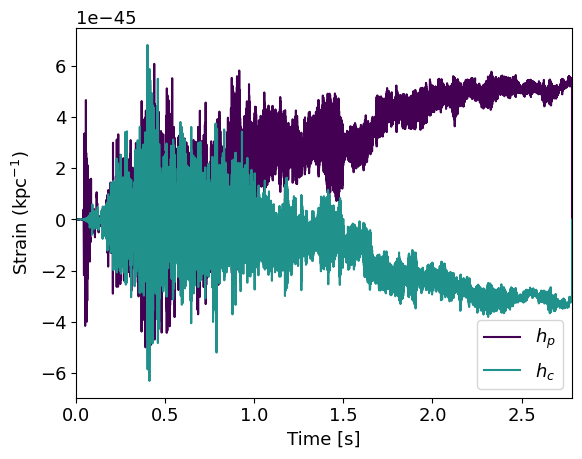

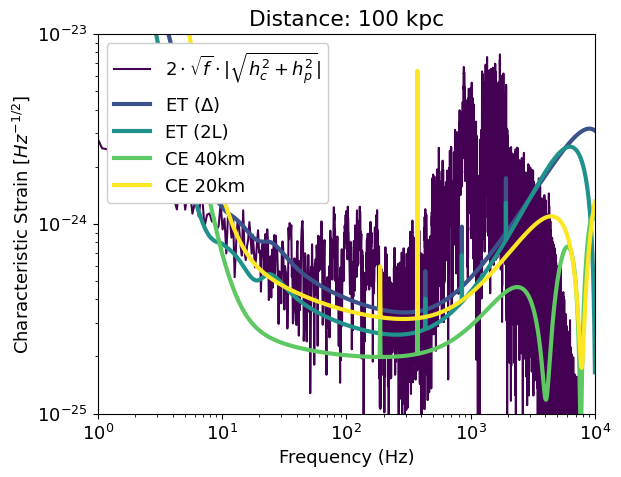

In [60]:
# compare the strains to the ET psd
from pathlib import Path 

psd_path = Path("GWFish/detector_psd")

kpc_to_cm   = const.kpc.to('cm').value
dist        = 100 * kpc_to_cm # 100 kpc in cm
const_corr  = 1 / dist

filename = "15.01_gwstrain_full.dat"

t_in, hp_in, hc_in = np.loadtxt(filename, unpack=True)
hp_in = hp_in * const_corr
hc_in = hc_in * const_corr

cmap = plt.get_cmap('viridis', 5)
colors = cmap(np.arange(5))

plt.figure()
plt.plot(t_in, hp_in*const_corr * 100, label = '$h_p$', color=colors[0])
plt.plot(t_in, hc_in*const_corr * 100, label = '$h_c$', color=colors[2])
plt.xlabel('Time [s]')
plt.ylabel('Strain ($\\text{kpc}^{-1}$)')
plt.legend()
plt.xlim(0, max(t_in))
plt.show()

dt = np.mean(np.diff(t_in)) #the time step is not quite constant for this particular dataset, resampling would be necessary but it gives close enough results to be illustrative
df = 1 / (max(t_in) - min(t_in))

hc_freq, freq_range = util.make_fft_from_time_series(hc_in, df, dt)
hp_freq, _          = util.make_fft_from_time_series(hp_in, df, dt)

abs_h = np.abs(np.sqrt(hc_freq**2 + hp_freq**2)) * freq_range ** 0.5

#Get the psd of the data
f_ET, psd_ET                    = np.loadtxt(psd_path / 'ET_full.txt').T
f_CE40, psd_CE40                = np.loadtxt(psd_path / 'CE40km_full.txt').T
f_CE20, psd_CE20                = np.loadtxt(psd_path / 'CE20km_full.txt').T
f_ET_triangle, psd_ET_triangle  = np.loadtxt(psd_path / 'ET15kmdata_freq_1_L.txt').T

plt.plot(freq_range, abs_h, label='$2 \\cdot \\sqrt{f} \\cdot |\\sqrt{h_c^2 + h_p^2}|$', color=colors[0])
plt.plot(f_ET, np.sqrt(psd_ET), label='ET ($\\Delta$)', linewidth=3, color=colors[1])
plt.plot(f_ET_triangle, np.sqrt(psd_ET_triangle), label='ET (2L)', linewidth=3, color=colors[2])
plt.plot(f_CE40, np.sqrt(psd_CE40), label='CE 40km', linewidth=3, color=colors[3])
plt.plot(f_CE20, np.sqrt(psd_CE20), label='CE 20km', linewidth=3, color=colors[4])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Characteristic Strain [$Hz^{-1/2}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 1e4)
plt.ylim(1e-25, 1e-23)
plt.legend(loc='upper left', framealpha=1)
plt.tight_layout()
plt.savefig('temp/strain_psd_comparison.png')
plt.title(f"Distance: {dist / kpc_to_cm:.0f} kpc")
plt.show()

In [5]:
import multiprocessing as mp

def snr_func(f_in, hp_f, hc_f, network, params, ra, dec):
        # skip f = 0 (the mean)
        f_input = f_in
        hp_f_in = hp_f
        hc_f_in = hc_f
        if f_in[0] == 0:
            f_input = f_in[1:]
            hp_f_in = hp_f_in[1:]
            hc_f_in = hc_f_in[1:]

        params["dec"] = dec
        params["ra"] = ra
        component_SNRs = util.get_SNR_from_series(f_input, hp_f_in, hc_f_in, network, params, long_wavelength_approx=False)
        out_SNR = np.sqrt(np.sum(component_SNRs**2))
        return ra, dec, out_SNR

def calculate_snr(f_in, hp_freq, hc_freq, network, params, n_points=400):
    ra = np.random.uniform(0., 2 * np.pi, n_points)
    dec = np.arcsin(np.random.uniform(-1, 1, n_points))
    ra_dec = zip(ra, dec)

    args_list = [
        (f_in, hp_freq, hc_freq, network, params, ra, dec) for ra, dec in ra_dec
    ]

    cores = mp.cpu_count()
    with mp.Pool(cores) as pool:
        snr_sub = pool.starmap(snr_func, args_list)

    return snr_sub

def calculate_network(freq, hp, hc, detectors, params):
    network = detection.Network(detector_ids = detectors_network_1)
    snr_sub = calculate_snr(freq[:, None], hp, hc, network, params)
    return snr_sub

detectors_network_1 = ['ET']
detectors_network_2 = ['ET', 'CE2']
detectors_network_3 = ['ET', 'CE2', 'CE1']
all_networks        = [detectors_network_1, detectors_network_2, detectors_network_3]
snr_sub, snr_sub_2, snr_sub_3 = (calculate_network(freq_range, hp_freq, hc_freq, detectors, params) for detectors in all_networks)


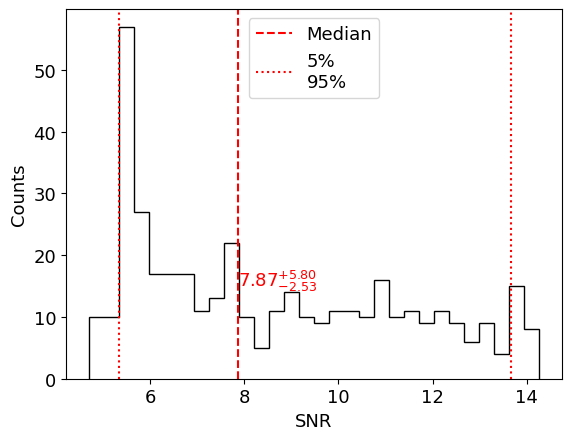

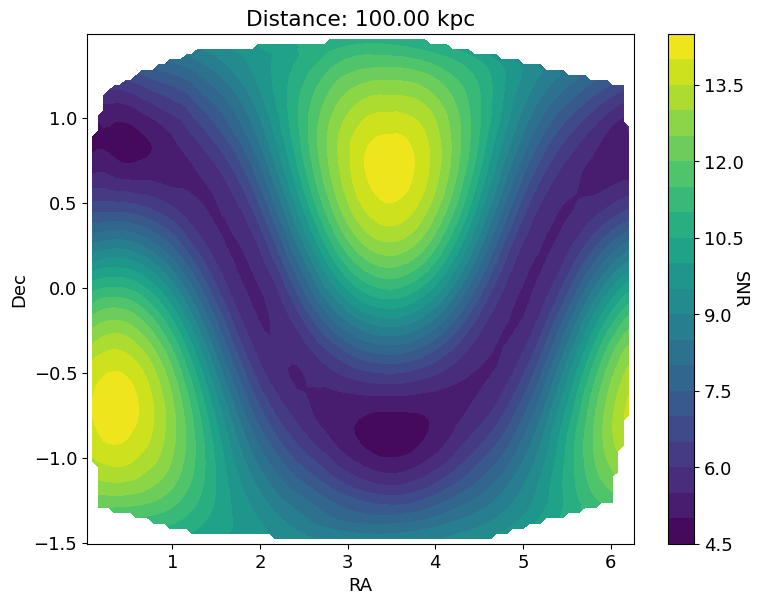

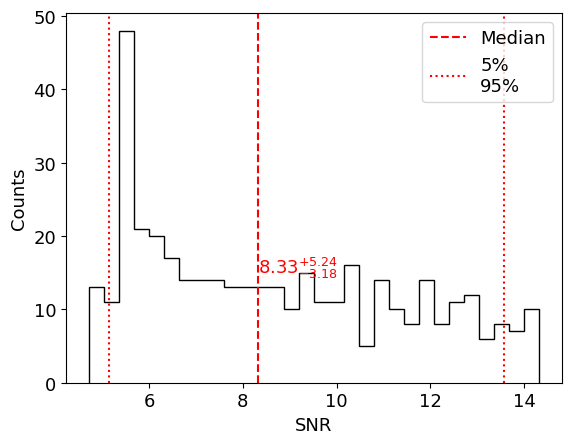

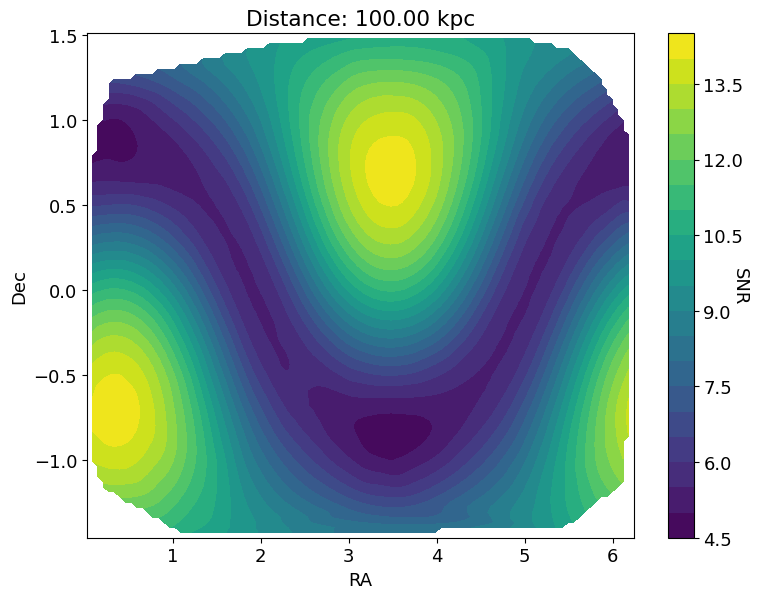

In [61]:
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt

def plot_snr_distribution(snr_sub, dist, kpc_to_cm):
    ra, dec, out_SNR = np.array(snr_sub).T

    median_SNR = np.median(out_SNR)
    th5_percentile = np.percentile(out_SNR, 5)
    th95_percentile = np.percentile(out_SNR, 95)

    plt.figure()
    plt.hist(out_SNR, bins=30, histtype='step', color='k')
    #plot the median SNR with a line
    plt.axvline(np.median(out_SNR), color='r', linestyle='--', label=f"Median")
    #add lines in the 5th and 95th percentiles
    plt.axvline(th5_percentile, color='r', linestyle=':', label="5%\n95%")
    plt.axvline(th95_percentile, color='r', linestyle=':')
    plt.ylabel('Counts')
    plt.xlabel('SNR')

    #add a text that shows the median +- 5th and 95th percentiles something like median^(median-5th percentile)_(95th percentile-median)
    plt.text(median_SNR, 15, f"${median_SNR:.2f}^{{+{th95_percentile-median_SNR:.2f}}}_{{{th5_percentile-median_SNR:.2f}}}$", color='r')
    plt.legend()
    plt.show()

    x_ = ra
    y_ = dec
    z_ = out_SNR

    xi = np.linspace(x_.min(), x_.max(), 100)
    yi = np.linspace(y_.min(), y_.max(), 100)
    X, Y = np.meshgrid(xi, yi)

    # Interpolate the data onto the grid
    Z = griddata((x_, y_), z_, (X, Y), method='cubic')

    # Create the contour plot
    plt.figure(figsize=(8, 6))
    CS = plt.contourf(X, Y, Z, 20, cmap='viridis')
    cbar = plt.colorbar(CS)
    cbar.set_label('SNR', rotation=270)
    # Customize the plot
    plt.xlabel('RA')
    plt.ylabel('Dec')
    plt.tight_layout()
    plt.savefig('temp/snr_distribution.png')
    plt.title(f'Distance: {dist / kpc_to_cm:.2f} kpc')
    plt.show()

# Example usage
plot_snr_distribution(snr_sub, dist, kpc_to_cm)
plot_snr_distribution(snr_sub_2, dist, kpc_to_cm)

In [7]:
datasn = Path("gwstrain").glob("*.dat")

snr_data = {}

def calculate_snr_for_networks(freq_range, hp_freq, hc_freq, networks, params):
    snr_results = []
    for network in networks:
        snr_sub = calculate_snr(freq_range[:, None], hp_freq, hc_freq, network, params)
        snr_results.append(snr_sub)
    return snr_results

detectors_network_1 = ['ET']
detectors_network_2 = ['ET', 'CE2']
detectors_network_3 = ['ET', 'CE2', 'CE1']
all_networks = [detectors_network_1, detectors_network_2, detectors_network_3]
networks = [detection.Network(detector_ids = detectors) for detectors in all_networks]

for data in datasn:
    t_in, hp_in, hc_in = np.loadtxt(data, unpack=True)
    hp_in = hp_in * const_corr
    hc_in = hc_in * const_corr

    dt = np.mean(np.diff(t_in)) #the time step is not quite constant for this particular dataset, resampling would be necessary but it gives close enough results to be illustrative
    df = 1 / (max(t_in) - min(t_in))

    hc_freq, freq_range = util.make_fft_from_time_series(hc_in, df, dt)
    hp_freq, _          = util.make_fft_from_time_series(hp_in, df, dt)

    snr_results         = calculate_snr_for_networks(freq_range, hp_freq, hc_freq, networks, params)

    snr_data[data]      = snr_results

In [8]:
datasn = Path("gwstrain").glob("*.dat")

network_4   = detection.Network(detector_ids=['ETS_15', 'ETN_15'])
network_5   = detection.Network(detector_ids=['ETS_15', 'ETN_15', 'CE2'])
network_6   = detection.Network(detector_ids=['ETS_15', 'ETN_15', 'CE2', 'CE1'])
networks_triangle = [network_4, network_5, network_6]
snr_data_triangle = {}

for data in datasn:
    t_in, hp_in, hc_in = np.loadtxt(data, unpack=True)
    hp_in = hp_in * const_corr
    hc_in = hc_in * const_corr

    dt = np.mean(np.diff(t_in)) #the time step is not quite constant for this particular dataset, resampling would be necessary but it gives close enough results to be illustrative
    df = 1 / (max(t_in) - min(t_in))

    hc_freq, freq_range = util.make_fft_from_time_series(hc_in, df, dt)
    hp_freq, _ = util.make_fft_from_time_series(hp_in, df, dt)

    snr_results = calculate_snr_for_networks(freq_range, hp_freq, hc_freq, networks_triangle, params)

    snr_data_triangle[data] = snr_results

In [9]:
from IPython.display import display, Math

def create_snr_table(snr_data: dict, labels: list, string_to_remove: str = "_gwstrain_trim.dat") -> str:
    """
    Create LaTeX table comparing SNR results for different networks
    
    Args:
        snr_data: Dictionary containing SNR data for different files
        labels: List of labels for the networks
        string_to_remove: Substring to remove from file names for display
    """
    # Build header
    header = r"\begin{array}{l" + "c" * len(labels) + "}"
    header += r"\hline" + "\n"
    header += r"M_{\odot} & " + " & ".join(labels) + r" \\\hline" + "\n"
    
    # Start table
    table = header
    
    # Add rows
    sorted_snr_data = sorted(snr_data.items(), key=lambda item: np.median([x[2] for x in item[1][0]]), reverse=True)

    for key, values in sorted_snr_data:
        key_pring = key.name.replace(string_to_remove, "")
        row = f"{key_pring}"
        
        for i in range(len(labels)):
            top_5 = np.percentile([x[2] for x in values[i]], 95)
            bot_5 = np.percentile([x[2] for x in values[i]], 5)
            median = np.median([x[2] for x in values[i]])
            result = f"{median:.2f}_{{-{median - bot_5:.2f}}}^{{+{top_5 - median:.2f}}}"
            row += f" & {result}"
        
        row += r" \\"
        table += row + "\n"
    
    # Close table
    table += r"\hline\end{array}"
    
    return table

# Generate the table
#distance
print(f"ET(Δ) vs ET(2L) for:  {Distance(dist, unit=u.cm).to(u.kpc):.0f}") 

labels = ["ET(Δ)", "ET(Δ)+CE40km", "ET(Δ)+CE40km+CE20km"]
snr_table = create_snr_table(snr_data, labels)
display(Math(snr_table))

labels_triangle = ["ET(2L)", "ET(2L)+CE40km", "ET(2L)+CE20km+CE40km"]
snr_table_triangle = create_snr_table(snr_data_triangle, labels_triangle)
display(Math(snr_table_triangle))

ET(Δ) vs ET(2L) for:  100 kpc


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
def get_snr_from_data(data, distance, networks, params):
    const_corr = 1/distance
    t_in, hp_in, hc_in = np.loadtxt(data, unpack=True)
    hp_in = hp_in * const_corr
    hc_in = hc_in * const_corr

    dt = np.mean(np.diff(t_in)) #the time step is not quite constant for this particular dataset, resampling would be necessary but it gives close enough results to be illustrative
    df = 1 / (max(t_in) - min(t_in))

    hc_freq, freq_range = util.make_fft_from_time_series(hc_in, df, dt)
    hp_freq, _ = util.make_fft_from_time_series(hp_in, df, dt)

    snr_results = calculate_snr_for_networks(freq_range, hp_freq, hc_freq, networks, params)
    return snr_results #output is (N_networks, N_points, (ra, dec, SNR)) 

datasn          = Path("gwstrain").glob("*.dat")
distances       = np.array([10, 30, 40, 50, 100])
snr_distance    = {}

for data in datasn:
    snr_temp = []
    for distance in distances:
        snr_temp.append(get_snr_from_data(data, distance * kpc_to_cm, networks, params)) 
    snr_distance[data] = snr_temp

In [12]:
#repeat the above code for networks_triangle
datasn          = Path("gwstrain").glob("*.dat")
distances       = np.array([10, 30, 40, 50, 100])
snr_distance_triangle    = {}

for data in datasn:
    snr_temp = []
    for distance in distances:
        snr_temp.append(get_snr_from_data(data, distance * kpc_to_cm, networks_triangle, params)) 
    snr_distance_triangle[data] = snr_temp

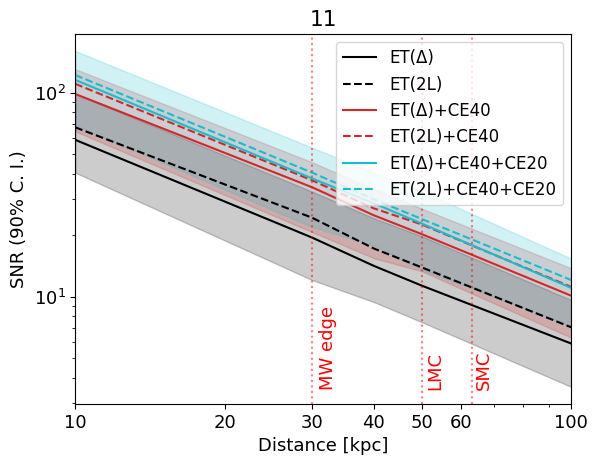

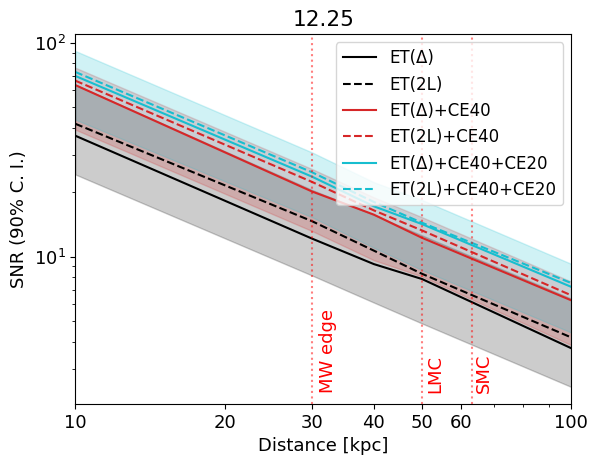

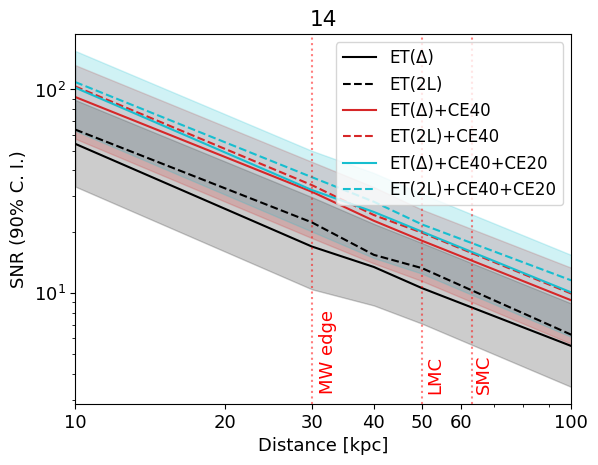

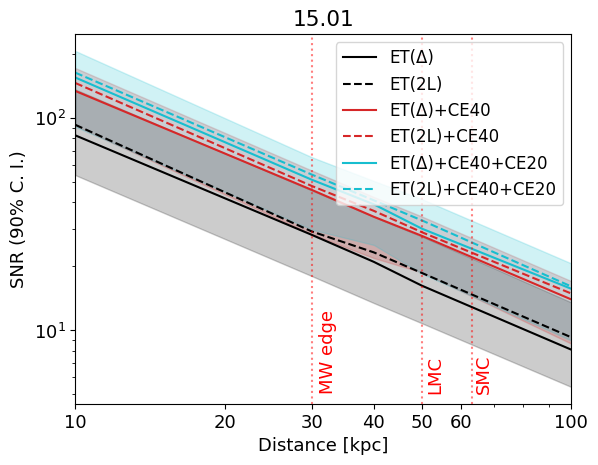

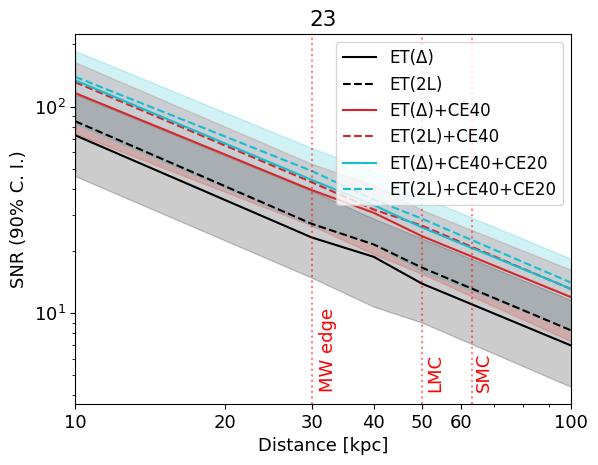

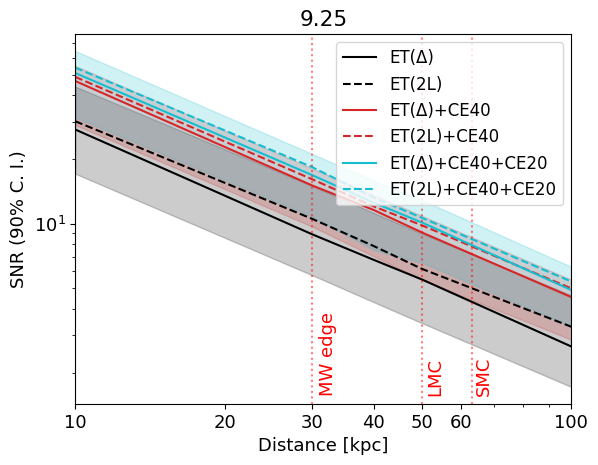

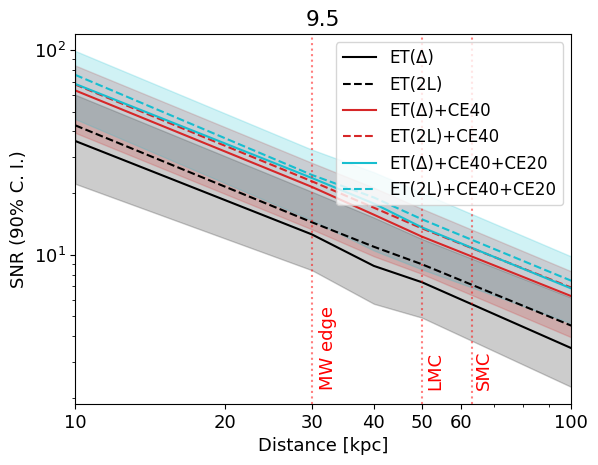

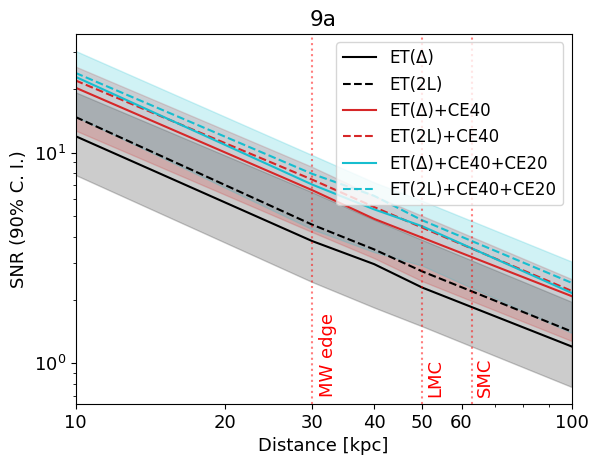

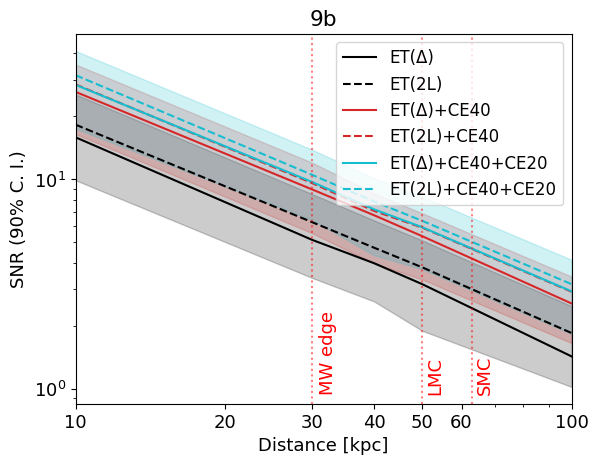

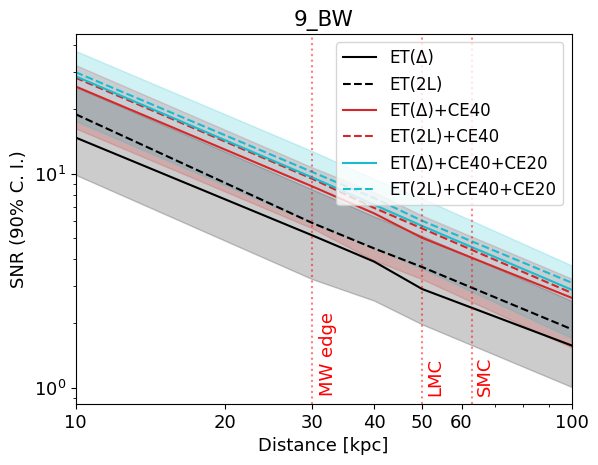

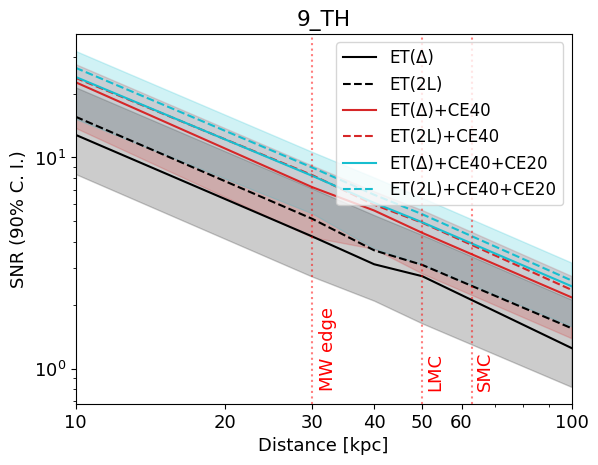

In [62]:
datasn = Path("gwstrain").glob("*.dat")
distances = np.array([10, 30, 40, 50, 100])

important_values = [30, 50, 63]

labels_distance = ["MW edge", "LMC", "SMC"]

labels = ["ET(Δ)", "ET(Δ)+CE40km", "ET(Δ)+CE40km+CE20km"]
labels_2L = ["ET(2L)", "ET(2L)+CE40km", "ET(2L)+CE20km+CE40km"]

labels = ["ET(Δ)", "ET(Δ)+CE40", "ET(Δ)+CE40+CE20"]
labels_2L = ["ET(2L)", "ET(2L)+CE40", "ET(2L)+CE40+CE20"]

n_col = 8
cmap = plt.get_cmap('plasma', n_col)
colors = cmap(np.arange(n_col))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
colors  = ["k", "#d62728", "#17becf"]
#plot the median vs distance
for data in datasn:
    data_snr    = snr_distance[data]
    for i_n, network in enumerate(networks):
        # data SNR is (N_dist, N_det, N_points, 3) where the 3rd is the snr, get the median vs distance
        dist_med = []
        dist_med_2L_ET = []
        dist_05 = []
        dist_95 = []
        dist_05_2L_ET = []
        dist_95_2L_ET = []
        for i_d, d in enumerate(distances):
            #if i_n == 0: #ET(2L) solo
            dist_med_2L_ET.append(np.median([x[2] for x in snr_distance_triangle[data][i_d][i_n]]))
            dist_med.append(np.median([x[2] for x in data_snr[i_d][i_n]]))
            dist_05.append(np.percentile([x[2] for x in data_snr[i_d][i_n]], 5))
            dist_95.append(np.percentile([x[2] for x in data_snr[i_d][i_n]], 95))
            dist_05_2L_ET.append(np.percentile([x[2] for x in snr_distance_triangle[data][i_d][i_n]], 5))
            dist_95_2L_ET.append(np.percentile([x[2] for x in snr_distance_triangle[data][i_d][i_n]], 95))
        #if i_n == 0: 
        col = colors[i_n]
        plt.plot(distances, dist_med, label=labels[i_n], color =col)
        plt.fill_between(distances, dist_05, dist_95, alpha=0.2, color = col)
        plt.plot(distances, dist_med_2L_ET, label=labels_2L[i_n], linestyle='--', color = col)
        #plt.fill_between(distances, dist_05_2L_ET, dist_95_2L_ET, alpha=0.2)
    min_val = np.min(dist_med)
    #plot the important distances
    for imv in important_values : 
        plt.axvline(imv, color='r', linestyle=':', alpha=0.5)
        #plt the text next to the line rotated 90 degrees
        plt.text(imv+1, min_val/3, labels_distance[important_values.index(imv)], color='r', rotation=90)

    plt.xlim(10, 100)
    plt.xlabel('Distance [kpc]')
    plt.ylabel('SNR (90% C. I.)')
    plt.legend(loc='upper right', fontsize=12)
    plt.xscale('log')
    plt.yscale('log')
    #change the xticks to be 10, 20, 30, 40, 60 and 100 instead of the powers representation
    plt.xticks([10, 20, 30, 40, 50, 60, 100], [10, 20, 30, 40, 50, 60, 100])

    plt.savefig(f"temp/combined_{data.name.replace('_gwstrain_trim.dat', '')}_snr_vs_distance.png")
    plt.title(f"{data.name.replace('_gwstrain_trim.dat', '')}")
    plt.show()

In [33]:
import numpy as np
import pandas as pd
from pathlib import Path

# Assume the following are defined/imported in the notebook:
# - snr_distance: dict mapping each data file (Path) to an array of SNR data
#               with shape (N_dist, N_det, N_points, 3) where x[2] is the SNR.
# - networks: list of network objects corresponding to the SNR data, e.g.,
#             networks = [network_ET_delta, network_ET_delta_CE40, network_ET_delta_CE40_CE20]
# - distances: numpy array of distance values in kpc, e.g., np.array([10, 30, 40, 50, 100])
# - labels: list of labels for networks, e.g., ["ET(Δ)", "ET(Δ)+CE40km", "ET(Δ)+CE40km+CE20km"]

results_table = []
datasn = list(Path("gwstrain").glob("*.dat"))

for data in datasn:
    data_snr = snr_distance[data]  # shape: (N_dist, N_det, N_points, 3)
    for i_n, network in enumerate(networks):
        med_values = []
        p5_values = []
        p95_values = []
        # Loop over preset distances
        for i_d, d in enumerate(distances):
            # Extract SNR values (assumed to be at index 2)
            snr_vals = [x[2] for x in data_snr[i_d][i_n]]
            med_values.append(np.median(snr_vals))
            p5_values.append(np.percentile(snr_vals, 5))
            p95_values.append(np.percentile(snr_vals, 95))
        
        # Convert to arrays for interpolation
        med_values = np.array(med_values)
        p5_values = np.array(p5_values)
        p95_values = np.array(p95_values)
        distances_arr = np.array(distances)

        # We assume SNR decreases with distance, so reverse arrays to have increasing order in SNR.
        horizon_med = np.interp(10, med_values[::-1], distances_arr[::-1])
        horizon_p5 = np.interp(10, p5_values[::-1], distances_arr[::-1])
        horizon_p95 = np.interp(10, p95_values[::-1], distances_arr[::-1])
        
        results_table.append({
            "Waveform": data.name,
            "Network": labels[i_n],
            "Horizon (SNR=10) [kpc]": horizon_med,
            "90% CI Lower [kpc]": horizon_p5,
            "90% CI Upper [kpc]": horizon_p95
        })

df_results = pd.DataFrame(results_table)
print(df_results)

                   Waveform              Network  Horizon (SNR=10) [kpc]  \
0      11_gwstrain_trim.dat                ET(Δ)               62.123390   
1      11_gwstrain_trim.dat         ET(Δ)+CE40km              100.000000   
2      11_gwstrain_trim.dat  ET(Δ)+CE40km+CE20km              100.000000   
3   12.25_gwstrain_trim.dat                ET(Δ)               37.374394   
4   12.25_gwstrain_trim.dat         ET(Δ)+CE40km               68.769731   
5   12.25_gwstrain_trim.dat  ET(Δ)+CE40km+CE20km               80.117061   
6      14_gwstrain_trim.dat                ET(Δ)               55.684469   
7      14_gwstrain_trim.dat         ET(Δ)+CE40km               95.580227   
8      14_gwstrain_trim.dat  ET(Δ)+CE40km+CE20km              100.000000   
9   15.01_gwstrain_trim.dat                ET(Δ)               88.321286   
10  15.01_gwstrain_trim.dat         ET(Δ)+CE40km              100.000000   
11  15.01_gwstrain_trim.dat  ET(Δ)+CE40km+CE20km              100.000000   
12     23_gw

In [34]:
import numpy as np
import pandas as pd
from pathlib import Path

results_table = []
datasn = list(Path("gwstrain").glob("*.dat"))

for data in datasn:
    data_snr = snr_distance[data]  # shape: (N_dist, N_det, N_points, 3)
    for i_n, network in enumerate(networks):
        med_values = []
        p5_values = []
        p95_values = []
        # Loop over preset distances
        for i_d, d in enumerate(distances):
            # Extract SNR values (assumed to be at index 2)
            snr_vals = [x[2] for x in data_snr[i_d][i_n]]
            med_values.append(np.median(snr_vals))
            p5_values.append(np.percentile(snr_vals, 5))
            p95_values.append(np.percentile(snr_vals, 95))
        
        med_values = np.array(med_values)
        p5_values = np.array(p5_values)
        p95_values = np.array(p95_values)
        distances_arr = np.array(distances, dtype=float)

        # Fit SNR = a / distance for each statistic:
        # a = sum(SNR_i/d_i) / sum(1/d_i^2)
        a_med = np.sum(med_values / distances_arr) / np.sum(1.0 / distances_arr**2)
        a_p5  = np.sum(p5_values / distances_arr) / np.sum(1.0 / distances_arr**2)
        a_p95 = np.sum(p95_values / distances_arr) / np.sum(1.0 / distances_arr**2)
        
        # Horizon distance for SNR=10 is then a/10.
        horizon_med = a_med / 10.0
        horizon_p5  = a_p5 / 10.0
        horizon_p95 = a_p95 / 10.0
        
        results_table.append({
            "Waveform": data.name.replace('_gwstrain_trim.dat', ''),
            "Network": labels[i_n],
            "Horizon (SNR=10) [kpc]": horizon_med,
            "90% CI Lower [kpc]": horizon_p5,
            "90% CI Upper [kpc]": horizon_p95
        })

df_results = pd.DataFrame(results_table)
print(df_results)

   Waveform              Network  Horizon (SNR=10) [kpc]  90% CI Lower [kpc]  \
0        11                ET(Δ)               58.447850           39.807628   
1        11         ET(Δ)+CE40km               98.972999           64.219278   
2        11  ET(Δ)+CE40km+CE20km              115.074505           68.935747   
3     12.25                ET(Δ)               36.842859           24.282094   
4     12.25         ET(Δ)+CE40km               63.063040           39.288863   
5     12.25  ET(Δ)+CE40km+CE20km               70.073976           43.929514   
6        14                ET(Δ)               53.704034           33.306768   
7        14         ET(Δ)+CE40km               91.893487           57.061719   
8        14  ET(Δ)+CE40km+CE20km              101.297343           62.200331   
9     15.01                ET(Δ)               82.899781           53.806714   
10    15.01         ET(Δ)+CE40km              134.594812           91.051662   
11    15.01  ET(Δ)+CE40km+CE20km        

In [44]:
import numpy as np
from pathlib import Path

# Assume the following variables are defined in the context:
# snr_distance      : dict mapping each data file to an array with shape (N_dist, N_det, N_points, 3)
# snr_distance_triangle : similar structure for 2L data
# distances         : numpy array of distances (kpc), e.g. np.array([10, 30, 40, 50, 100])
# networks          : list of network objects corresponding to snr_distance
# labels            : list of labels for the standard networks (e.g. ["ET(Δ)", "ET(Δ)+CE40km", "ET(Δ)+CE40km+CE20km"])
# labels_2L         : list of labels for the 2L networks (e.g. ["ET(2L)", "ET(2L)+CE40km", "ET(2L)+CE20km+CE40km"])

results_rows = []

# Process standard networks
datasn = list(Path("gwstrain").glob("*.dat"))
for data in datasn:
    data_snr = snr_distance[data]  # shape: (N_dist, N_det, N_points, 3)
    for i_n, network in enumerate(networks):
        med_values = []
        p5_values = []
        p95_values = []
        for i_d, d in enumerate(distances):
            # Extract SNR values (assumed index 2)
            snr_vals = [x[2] for x in data_snr[i_d][i_n]]
            med_values.append(np.median(snr_vals))
            p5_values.append(np.percentile(snr_vals, 5))
            p95_values.append(np.percentile(snr_vals, 95))
        
        med_values = np.array(med_values)
        p5_values = np.array(p5_values)
        p95_values = np.array(p95_values)
        distances_arr = np.array(distances, dtype=float)
        
        # Fit SNR = a / x using least-squares: a = sum(SNR_i/x_i)/sum(1/x_i^2)
        a_med = np.sum(med_values/distances_arr) / np.sum(1.0/distances_arr**2)
        a_p5  = np.sum(p5_values/distances_arr)  / np.sum(1.0/distances_arr**2)
        a_p95 = np.sum(p95_values/distances_arr) / np.sum(1.0/distances_arr**2)
        
        # Horizon at SNR=10:
        horizon_med = a_med / 10.0
        horizon_p5  = a_p5 / 10.0
        horizon_p95 = a_p95 / 10.0
        
        # Compute uncertainties (differences)
        diff_lower = horizon_med - horizon_p5
        diff_upper = horizon_p95 - horizon_med
        
        # Create a MathTeX formatted string: e.g. "$H= 50^{+10}_{-8}$"
        value_str = f"$ {horizon_med:.2f}^{{+{diff_upper:.2f}}}_{{-{diff_lower:.2f}}} $"
        
        results_rows.append({
            "Waveform": data.name,
            "Network": labels[i_n],
            "Horizon": value_str
        })

# Process 2L networks from triangle data
for data in datasn:
    data_snr_2L = snr_distance_triangle[data]  # shape similar to data_snr
    for i_n, network in enumerate(networks):  # assume same index order corresponds to labels_2L
        med_values = []
        p5_values = []
        p95_values = []
        for i_d, d in enumerate(distances):
            snr_vals = [x[2] for x in data_snr_2L[i_d][i_n]]
            med_values.append(np.median(snr_vals))
            p5_values.append(np.percentile(snr_vals, 5))
            p95_values.append(np.percentile(snr_vals, 95))
        
        med_values = np.array(med_values)
        p5_values = np.array(p5_values)
        p95_values = np.array(p95_values)
        distances_arr = np.array(distances, dtype=float)
        
        a_med = np.sum(med_values/distances_arr) / np.sum(1.0/distances_arr**2)
        a_p5  = np.sum(p5_values/distances_arr)  / np.sum(1.0/distances_arr**2)
        a_p95 = np.sum(p95_values/distances_arr) / np.sum(1.0/distances_arr**2)
        
        horizon_med = a_med / 10.0
        horizon_p5  = a_p5 / 10.0
        horizon_p95 = a_p95 / 10.0
        
        diff_lower = horizon_med - horizon_p5
        diff_upper = horizon_p95 - horizon_med
        
        value_str = f"$ {horizon_med:.0f}^{{+{diff_upper:.0f}}}_{{-{diff_lower:.0f}}} $"
        
        results_rows.append({
            "Waveform": data.name,
            "Network": labels_2L[i_n],
            "Horizon": value_str
        })

# Build LaTeX table string
table_lines = []
table_lines.append("\\begin{tabular}{lll}")
table_lines.append("\\hline")
table_lines.append("Waveform & Network & Horizon (SNR=10) [kpc] \\\\")
table_lines.append("\\hline")
for row in results_rows:
    line = f"{row['Waveform']} & {row['Network']} & {row['Horizon']} \\\\"
    table_lines.append(line)
table_lines.append("\\hline")
table_lines.append("\\end{tabular}")

table_tex = "\n".join(table_lines)
print(table_tex)

\begin{tabular}{lll}
\hline
Waveform & Network & Horizon (SNR=10) [kpc] \\
\hline
11_gwstrain_trim.dat & ET(Δ) & $ 58.45^{+40.02}_{-18.64} $ \\
11_gwstrain_trim.dat & ET(Δ)+CE40km & $ 98.97^{+32.19}_{-34.75} $ \\
11_gwstrain_trim.dat & ET(Δ)+CE40km+CE20km & $ 115.07^{+45.10}_{-46.14} $ \\
12.25_gwstrain_trim.dat & ET(Δ) & $ 36.84^{+26.60}_{-12.56} $ \\
12.25_gwstrain_trim.dat & ET(Δ)+CE40km & $ 63.06^{+13.45}_{-23.77} $ \\
12.25_gwstrain_trim.dat & ET(Δ)+CE40km+CE20km & $ 70.07^{+21.46}_{-26.14} $ \\
14_gwstrain_trim.dat & ET(Δ) & $ 53.70^{+34.95}_{-20.40} $ \\
14_gwstrain_trim.dat & ET(Δ)+CE40km & $ 91.89^{+39.67}_{-34.83} $ \\
14_gwstrain_trim.dat & ET(Δ)+CE40km+CE20km & $ 101.30^{+52.78}_{-39.10} $ \\
15.01_gwstrain_trim.dat & ET(Δ) & $ 82.90^{+53.43}_{-29.09} $ \\
15.01_gwstrain_trim.dat & ET(Δ)+CE40km & $ 134.59^{+36.78}_{-43.54} $ \\
15.01_gwstrain_trim.dat & ET(Δ)+CE40km+CE20km & $ 154.72^{+50.70}_{-63.38} $ \\
23_gwstrain_trim.dat & ET(Δ) & $ 72.34^{+42.80}_{-26.63} $ \\
23_gws

In [63]:
import numpy as np
from pathlib import Path

results_rows = []
datasn = list(Path("gwstrain").glob("*.dat"))

# Process standard networks (e.g. labels = ["ET(Δ)", "ET(Δ)+CE40km", "ET(Δ)+CE40km+CE20km"])
for data in datasn:
    data_snr = snr_distance[data]  # shape: (N_dist, N_det, N_points, 3)
    
    # First, compute baseline for ET alone (network index 0)
    med_values_base, p5_values_base, p95_values_base = [], [], []
    for i_d, d in enumerate(distances):
        snr_vals = [x[2] for x in data_snr[i_d][0]]
        med_values_base.append(np.median(snr_vals))
        p5_values_base.append(np.percentile(snr_vals, 5))
        p95_values_base.append(np.percentile(snr_vals, 95))
    med_values_base = np.array(med_values_base)
    p5_values_base = np.array(p5_values_base)
    p95_values_base = np.array(p95_values_base)
    distances_arr = np.array(distances, dtype=float)
    
    # Fit SNR = a/x: a = sum(SNR_i/x_i)/sum(1/x_i^2)
    a_med_base = np.sum(med_values_base/distances_arr) / np.sum(1.0/distances_arr**2)
    a_p5_base  = np.sum(p5_values_base/distances_arr)  / np.sum(1.0/distances_arr**2)
    a_p95_base = np.sum(p95_values_base/distances_arr) / np.sum(1.0/distances_arr**2)
    
    baseline_med = a_med_base / 10.0      # horizon (SNR=10) for ET alone
    baseline_p5  = a_p5_base / 10.0
    baseline_p95 = a_p95_base / 10.0
    
    # Loop over all standard networks
    for i_n, network in enumerate(networks):
        med_values, p5_values, p95_values = [], [], []
        for i_d, d in enumerate(distances):
            snr_vals = [x[2] for x in data_snr[i_d][i_n]]
            med_values.append(np.median(snr_vals))
            p5_values.append(np.percentile(snr_vals, 5))
            p95_values.append(np.percentile(snr_vals, 95))
        
        med_values = np.array(med_values)
        p5_values = np.array(p5_values)
        p95_values = np.array(p95_values)
        
        a_med = np.sum(med_values/distances_arr) / np.sum(1.0/distances_arr**2)
        a_p5  = np.sum(p5_values/distances_arr)   / np.sum(1.0/distances_arr**2)
        a_p95 = np.sum(p95_values/distances_arr)  / np.sum(1.0/distances_arr**2)
        
        horizon_med = a_med / 10.0
        horizon_p5  = a_p5 / 10.0
        horizon_p95 = a_p95 / 10.0
        
        # Improvement ratio relative to ET-alone baseline
        improvement_med = horizon_med / baseline_med
        improvement_lower = (horizon_med - horizon_p5) / baseline_med
        improvement_upper = (horizon_p95 - horizon_med) / baseline_med
        
        # Format the result as a MathTeX string (ET-alone improvement is 1)
        value_str = f"$ {improvement_med:.2f}^{{+{improvement_upper:.2f}}}_{{-{improvement_lower:.2f}}} $"
        
        results_rows.append({
            "Waveform": data.name,
            "Network": labels[i_n],
            "Improvement": value_str
        })

# Process 2L networks (e.g., labels_2L = ["ET(2L)", "ET(2L)+CE40km", "ET(2L)+CE20km+CE40km"])
for data in datasn:
    data_snr_2L = snr_distance_triangle[data]  # similar structure as data_snr
    # Baseline for ET-alone in 2L configuration (network index 0)
    med_values_base, p5_values_base, p95_values_base = [], [], []
    for i_d, d in enumerate(distances):
        snr_vals = [x[2] for x in data_snr_2L[i_d][0]]
        med_values_base.append(np.median(snr_vals))
        p5_values_base.append(np.percentile(snr_vals, 5))
        p95_values_base.append(np.percentile(snr_vals, 95))
    med_values_base = np.array(med_values_base)
    p5_values_base = np.array(p5_values_base)
    p95_values_base = np.array(p95_values_base)
    distances_arr = np.array(distances, dtype=float)
    
    a_med_base = np.sum(med_values_base/distances_arr) / np.sum(1.0/distances_arr**2)
    a_p5_base  = np.sum(p5_values_base/distances_arr)  / np.sum(1.0/distances_arr**2)
    a_p95_base = np.sum(p95_values_base/distances_arr) / np.sum(1.0/distances_arr**2)
    
    baseline_med = a_med_base / 10.0
    baseline_p5  = a_p5_base / 10.0
    baseline_p95 = a_p95_base / 10.0
    
    for i_n, network in enumerate(networks):  # assume ordering corresponds to labels_2L
        med_values, p5_values, p95_values = [], [], []
        for i_d, d in enumerate(distances):
            snr_vals = [x[2] for x in data_snr_2L[i_d][i_n]]
            med_values.append(np.median(snr_vals))
            p5_values.append(np.percentile(snr_vals, 5))
            p95_values.append(np.percentile(snr_vals, 95))
        
        med_values = np.array(med_values)
        p5_values = np.array(p5_values)
        p95_values = np.array(p95_values)
        
        a_med = np.sum(med_values/distances_arr) / np.sum(1.0/distances_arr**2)
        a_p5  = np.sum(p5_values/distances_arr)  / np.sum(1.0/distances_arr**2)
        a_p95 = np.sum(p95_values/distances_arr) / np.sum(1.0/distances_arr**2)
        
        horizon_med = a_med / 10.0
        horizon_p5  = a_p5 / 10.0
        horizon_p95 = a_p95 / 10.0
        
        improvement_med = horizon_med / baseline_med
        improvement_lower = (horizon_med - horizon_p5) / baseline_med
        improvement_upper = (horizon_p95 - horizon_med) / baseline_med
        
        value_str = f"$ {improvement_med:.2f}^{{+{improvement_upper:.2f}}}_{{-{improvement_lower:.2f}}} $"
        
        results_rows.append({
            "Waveform": data.name,
            "Network": labels_2L[i_n],
            "Improvement": value_str
        })

# Build LaTeX table string with math formatting
table_lines = []
table_lines.append("\\begin{tabular}{lll}")
table_lines.append("\\hline")
table_lines.append("Waveform & Network & Improvement (relative to ET alone) \\\\")
table_lines.append("\\hline")
for row in results_rows:
    line = f"{row['Waveform']} & {row['Network']} & {row['Improvement']} \\\\"
    table_lines.append(line)
table_lines.append("\\hline")
table_lines.append("\\end{tabular}")

table_tex = "\n".join(table_lines)
print(table_tex)

\begin{tabular}{lll}
\hline
Waveform & Network & Improvement (relative to ET alone) \\
\hline
11_gwstrain_trim.dat & ET(Δ) & $ 1.00^{+0.68}_{-0.32} $ \\
11_gwstrain_trim.dat & ET(Δ)+CE40 & $ 1.69^{+0.55}_{-0.59} $ \\
11_gwstrain_trim.dat & ET(Δ)+CE40+CE20 & $ 1.97^{+0.77}_{-0.79} $ \\
12.25_gwstrain_trim.dat & ET(Δ) & $ 1.00^{+0.72}_{-0.34} $ \\
12.25_gwstrain_trim.dat & ET(Δ)+CE40 & $ 1.71^{+0.37}_{-0.65} $ \\
12.25_gwstrain_trim.dat & ET(Δ)+CE40+CE20 & $ 1.90^{+0.58}_{-0.71} $ \\
14_gwstrain_trim.dat & ET(Δ) & $ 1.00^{+0.65}_{-0.38} $ \\
14_gwstrain_trim.dat & ET(Δ)+CE40 & $ 1.71^{+0.74}_{-0.65} $ \\
14_gwstrain_trim.dat & ET(Δ)+CE40+CE20 & $ 1.89^{+0.98}_{-0.73} $ \\
15.01_gwstrain_trim.dat & ET(Δ) & $ 1.00^{+0.64}_{-0.35} $ \\
15.01_gwstrain_trim.dat & ET(Δ)+CE40 & $ 1.62^{+0.44}_{-0.53} $ \\
15.01_gwstrain_trim.dat & ET(Δ)+CE40+CE20 & $ 1.87^{+0.61}_{-0.76} $ \\
23_gwstrain_trim.dat & ET(Δ) & $ 1.00^{+0.59}_{-0.37} $ \\
23_gwstrain_trim.dat & ET(Δ)+CE40 & $ 1.62^{+0.64}_{-0.58} $ 

In [65]:
import numpy as np
from pathlib import Path

results_rows = []
datasn = list(Path("gwstrain").glob("*.dat"))

# Loop over each waveform data file
for data in datasn:
    # Process ET triangle horizons (standard networks from snr_distance)
    data_snr_tri = snr_distance[data]  # shape: (N_dist, N_det, N_points, 3)
    horizons_tri = []
    distances_arr = np.array(distances, dtype=float)
    for i_n, network in enumerate(networks):
        med_values_tri, p5_values_tri, p95_values_tri = [], [], []
        for i_d, d in enumerate(distances):
            snr_vals = [x[2] for x in data_snr_tri[i_d][i_n]]
            med_values_tri.append(np.median(snr_vals))
            p5_values_tri.append(np.percentile(snr_vals, 5))
            p95_values_tri.append(np.percentile(snr_vals, 95))
        med_values_tri = np.array(med_values_tri)
        p5_values_tri  = np.array(p5_values_tri)
        p95_values_tri = np.array(p95_values_tri)
        
        # Fit SNR = a/x: a = sum(SNR_i/x_i)/sum(1/x_i^2)
        a_med_tri = np.sum(med_values_tri/distances_arr) / np.sum(1.0/distances_arr**2)
        a_p5_tri  = np.sum(p5_values_tri/distances_arr) / np.sum(1.0/distances_arr**2)
        a_p95_tri = np.sum(p95_values_tri/distances_arr) / np.sum(1.0/distances_arr**2)
        
        h_med_tri = a_med_tri / 10.0
        h_p5_tri  = a_p5_tri / 10.0
        h_p95_tri = a_p95_tri / 10.0
        
        horizons_tri.append({
            "med": h_med_tri,
            "p5": h_p5_tri,
            "p95": h_p95_tri
        })
    
    # Process ET 2L horizons (from snr_distance_triangle)
    data_snr_2L = snr_distance_triangle[data]  # similar shape as data_snr_tri
    horizons_2L = []
    for i_n, network in enumerate(networks):  # assuming same ordering as labels_2L
        med_values_2L, p5_values_2L, p95_values_2L = [], [], []
        for i_d, d in enumerate(distances):
            snr_vals = [x[2] for x in data_snr_2L[i_d][i_n]]
            med_values_2L.append(np.median(snr_vals))
            p5_values_2L.append(np.percentile(snr_vals, 5))
            p95_values_2L.append(np.percentile(snr_vals, 95))
        med_values_2L = np.array(med_values_2L)
        p5_values_2L  = np.array(p5_values_2L)
        p95_values_2L = np.array(p95_values_2L)
        
        a_med_2L = np.sum(med_values_2L/distances_arr) / np.sum(1.0/distances_arr**2)
        a_p5_2L  = np.sum(p5_values_2L/distances_arr)  / np.sum(1.0/distances_arr**2)
        a_p95_2L = np.sum(p95_values_2L/distances_arr) / np.sum(1.0/distances_arr**2)
        
        h_med_2L = a_med_2L / 10.0
        h_p5_2L  = a_p5_2L / 10.0
        h_p95_2L = a_p95_2L / 10.0
        
        horizons_2L.append({
            "med": h_med_2L,
            "p5": h_p5_2L,
            "p95": h_p95_2L
        })
    
    # Compare the horizons for each network (assumed matching ordering)
    for i_n, network in enumerate(networks):
        # Ratio: ET triangle horizon / ET 2L horizon
        r_med = horizons_tri[i_n]["med"] / horizons_2L[i_n]["med"]
        # Lower bound: use triangle 5th percentile over 2L 95th percentile (conservative estimate)
        r_lower = horizons_tri[i_n]["p5"] / horizons_2L[i_n]["p95"]
        # Upper bound: use triangle 95th percentile over 2L 5th percentile
        r_upper = horizons_tri[i_n]["p95"] / horizons_2L[i_n]["p5"]
        diff_lower = r_med - r_lower
        diff_upper = r_upper - r_med
        
        # Create a combined label: e.g. "ET(Δ)/ET(2L)"
        network_label = f"{labels[i_n]}/{labels_2L[i_n]}"
        value_str = f"$ {r_med:.2f}^{{+{diff_upper:.2f}}}_{{-{diff_lower:.2f}}} $"
        
        results_rows.append({
            "Waveform": data.name,
            "Network": network_label,
            "Ratio": value_str
        })

# Build the LaTeX table string
table_lines = []
table_lines.append("\\begin{tabular}{lll}")
table_lines.append("\\hline")
table_lines.append("Waveform & Network & Horizon Ratio (ET$^\\Delta$/ET(2L)) \\\\")
table_lines.append("\\hline")
for row in results_rows:
    line = f"{row['Waveform']} & {row['Network']} & {row['Ratio']} \\\\"
    table_lines.append(line)
table_lines.append("\\hline")
table_lines.append("\\end{tabular}")

table_tex = "\n".join(table_lines)
print(table_tex)

\begin{tabular}{lll}
\hline
Waveform & Network & Horizon Ratio (ET$^\Delta$/ET(2L)) \\
\hline
11_gwstrain_trim.dat & ET(Δ)/ET(2L) & $ 0.86^{+1.47}_{-0.50} $ \\
11_gwstrain_trim.dat & ET(Δ)+CE40/ET(2L)+CE40 & $ 0.90^{+1.11}_{-0.45} $ \\
11_gwstrain_trim.dat & ET(Δ)+CE40+CE20/ET(2L)+CE40+CE20 & $ 0.95^{+1.12}_{-0.51} $ \\
12.25_gwstrain_trim.dat & ET(Δ)/ET(2L) & $ 0.88^{+1.43}_{-0.53} $ \\
12.25_gwstrain_trim.dat & ET(Δ)+CE40/ET(2L)+CE40 & $ 0.95^{+0.88}_{-0.47} $ \\
12.25_gwstrain_trim.dat & ET(Δ)+CE40+CE20/ET(2L)+CE40+CE20 & $ 0.96^{+1.01}_{-0.49} $ \\
14_gwstrain_trim.dat & ET(Δ)/ET(2L) & $ 0.84^{+1.54}_{-0.53} $ \\
14_gwstrain_trim.dat & ET(Δ)+CE40/ET(2L)+CE40 & $ 0.89^{+1.24}_{-0.48} $ \\
14_gwstrain_trim.dat & ET(Δ)+CE40+CE20/ET(2L)+CE40+CE20 & $ 0.93^{+1.31}_{-0.52} $ \\
15.01_gwstrain_trim.dat & ET(Δ)/ET(2L) & $ 0.90^{+1.36}_{-0.55} $ \\
15.01_gwstrain_trim.dat & ET(Δ)+CE40/ET(2L)+CE40 & $ 0.92^{+0.96}_{-0.43} $ \\
15.01_gwstrain_trim.dat & ET(Δ)+CE40+CE20/ET(2L)+CE40+CE20 & $ 0.

In [72]:
import numpy as np
from pathlib import Path

results_rows = []
datasn = list(Path("gwstrain").glob("*.dat"))

# Loop over each waveform data file
for data in datasn:
    # Process ET Δ horizons (from snr_distance)
    data_snr_delta = snr_distance[data]  # shape: (N_dist, N_det, N_points, 3)
    horizons_delta = []  # ET Δ horizons
    distances_arr = np.array(distances, dtype=float)
    for i_n, network in enumerate(networks):
        med_values, p5_values, p95_values = [], [], []
        for i_d, d in enumerate(distances):
            snr_vals = [x[2] for x in data_snr_delta[i_d][i_n]]
            med_values.append(np.median(snr_vals))
            p5_values.append(np.percentile(snr_vals, 5))
            p95_values.append(np.percentile(snr_vals, 95))
        med_values = np.array(med_values)
        p5_values  = np.array(p5_values)
        p95_values = np.array(p95_values)
        
        a_med = np.sum(med_values/distances_arr) / np.sum(1.0/distances_arr**2)
        a_p5  = np.sum(p5_values/distances_arr)  / np.sum(1.0/distances_arr**2)
        a_p95 = np.sum(p95_values/distances_arr) / np.sum(1.0/distances_arr**2)
        
        h_med = a_med / 10.0
        h_p5  = a_p5 / 10.0
        h_p95 = a_p95 / 10.0
        
        horizons_delta.append({
            "med": h_med,
            "p5": h_p5,
            "p95": h_p95
        })
    
    # Process ET 2L horizons (from snr_distance_triangle)
    data_snr_2L = snr_distance_triangle[data]  # similar shape as data_snr_delta
    horizons_2L = []
    for i_n, network in enumerate(networks):  # assume same ordering as labels_2L
        med_values, p5_values, p95_values = [], [], []
        for i_d, d in enumerate(distances):
            snr_vals = [x[2] for x in data_snr_2L[i_d][i_n]]
            med_values.append(np.median(snr_vals))
            p5_values.append(np.percentile(snr_vals, 5))
            p95_values.append(np.percentile(snr_vals, 95))
        med_values = np.array(med_values)
        p5_values  = np.array(p5_values)
        p95_values = np.array(p95_values)
        
        a_med = np.sum(med_values/distances_arr) / np.sum(1.0/distances_arr**2)
        a_p5  = np.sum(p5_values/distances_arr)  / np.sum(1.0/distances_arr**2)
        a_p95 = np.sum(p95_values/distances_arr) / np.sum(1.0/distances_arr**2)
        
        h_med = a_med / 10.0
        h_p5  = a_p5 / 10.0
        h_p95 = a_p95 / 10.0
        
        horizons_2L.append({
            "med": h_med,
            "p5": h_p5,
            "p95": h_p95
        })
    
    # Compare the horizons for each network:
    for i_n, network in enumerate(networks):
        # Ratio: ET2L / ET Δ
        r_med   = horizons_2L[i_n]["med"] / horizons_delta[i_n]["med"]
        r_lower = horizons_2L[i_n]["p5"] / horizons_delta[i_n]["p95"]
        r_upper = horizons_2L[i_n]["p95"] / horizons_delta[i_n]["p5"]
        diff_lower = r_med - r_lower
        diff_upper = r_upper - r_med
        
        # Create network label with "Δ" replaced by LaTeX code
        net_label_delta = labels[i_n].replace("Δ", "$\\Delta$")
        network_label = f"{labels_2L[i_n]}/{net_label_delta}"
        
        # Remove "gwstrain" from the waveform file name
        waveform_name = data.name.replace("_gwstrain_trim.dat", "")
        
        value_str = f"$ {r_med:.2f}^{{+{diff_upper:.2f}}}_{{-{diff_lower:.2f}}} $"
        
        results_rows.append({
            "Waveform": waveform_name,
            "Network": network_label,
            "Ratio": value_str,
            "r_med_value" : r_med
        })

# Build the LaTeX table string
table_lines = []
table_lines.append("\\begin{tabular}{lll}")
table_lines.append("\\hline")
table_lines.append("Waveform & Network & Horizon Ratio (ET2L/ET$^\\Delta$) \\\\")
table_lines.append("\\hline")
for row in results_rows:
    line = f"{row['Waveform']} & {row['Network']} & {row['Ratio']} \\\\"
    table_lines.append(line)
table_lines.append("\\hline")
table_lines.append("\\end{tabular}")

table_tex = "\n".join(table_lines)
print(table_tex)

\begin{tabular}{lll}
\hline
Waveform & Network & Horizon Ratio (ET2L/ET$^\Delta$) \\
\hline
11 & ET(2L)/ET($\Delta$) & $ 1.17^{+1.67}_{-0.74} $ \\
11 & ET(2L)+CE40/ET($\Delta$)+CE40 & $ 1.12^{+1.13}_{-0.62} $ \\
11 & ET(2L)+CE40+CE20/ET($\Delta$)+CE40+CE20 & $ 1.06^{+1.26}_{-0.57} $ \\
12.25 & ET(2L)/ET($\Delta$) & $ 1.14^{+1.79}_{-0.71} $ \\
12.25 & ET(2L)+CE40/ET($\Delta$)+CE40 & $ 1.05^{+1.02}_{-0.51} $ \\
12.25 & ET(2L)+CE40+CE20/ET($\Delta$)+CE40+CE20 & $ 1.04^{+1.08}_{-0.54} $ \\
14 & ET(2L)/ET($\Delta$) & $ 1.19^{+2.04}_{-0.77} $ \\
14 & ET(2L)+CE40/ET($\Delta$)+CE40 & $ 1.12^{+1.31}_{-0.65} $ \\
14 & ET(2L)+CE40+CE20/ET($\Delta$)+CE40+CE20 & $ 1.08^{+1.37}_{-0.63} $ \\
15.01 & ET(2L)/ET($\Delta$) & $ 1.11^{+1.80}_{-0.67} $ \\
15.01 & ET(2L)+CE40/ET($\Delta$)+CE40 & $ 1.08^{+0.93}_{-0.55} $ \\
15.01 & ET(2L)+CE40+CE20/ET($\Delta$)+CE40+CE20 & $ 1.06^{+1.26}_{-0.55} $ \\
23 & ET(2L)/ET($\Delta$) & $ 1.17^{+1.81}_{-0.72} $ \\
23 & ET(2L)+CE40/ET($\Delta$)+CE40 & $ 1.12^{+1.14}_{-0

In [73]:
print("Average Improvement (ET2L/ET$^\\Delta$): {:.2f}".format(np.mean([row["r_med_value"] for row in results_rows])))

Average Improvement (ET2L/ET$^\Delta$): 1.11
